### keypoints
learn 
- vorticity again
- data coarse

![](https://camo.githubusercontent.com/48c4638693336f18e762ad4a071858f9a92096b6e82bc1f9fce3cb8c14b8c109/687474703a2f2f6d697467636d2e6f72672f77702d636f6e74656e742f75706c6f6164732f323031392f30342f626c75656d6172626c655f737572666163655f63757272656e74735f6c6c63343332305f736c722e6a7067)

In [1]:
import intake
cat_url = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/master.yaml'
cat = intake.open_catalog(cat_url)

In [2]:
sst = cat.ocean.LLC4320.LLC4320_SST.to_dask()
ssh = cat.ocean.LLC4320.LLC4320_SSH.to_dask()
u = cat.ocean.LLC4320.LLC4320_SSU.to_dask()
v =  cat.ocean.LLC4320.LLC4320_SSV.to_dask()

In [3]:
sst['SST'].data

dask.array<open_dataset-9b10624b30572e907c6def9a1cef7105SST, shape=(9030, 13, 4320, 4320), dtype=float32, chunksize=(1, 1, 4320, 4320), chunktype=numpy.ndarray>

### That's a lot of data! This xarray data array holds almost 9 TB of sea surface temperature data! We can see from the table that to split this big data set into manageable peices, dask is working behind the scenes to chunk the dataset along the first two dimensions, resulting in manageable 75 MB chunks.

In [4]:
sst

<xarray.Dataset>
Dimensions:  (time: 9030, face: 13, j: 4320, i: 4320)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
Data variables:
    SST      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...
    source:       MITgcm
    title:        netCDF wrapper of MITgcm MDS binary data

### In the chunking visualization above, we see that the data array has been chunked along one dimension with size 9030 (which we recognize as the "time" dimension) and a second dimension with size 13 (which we recognize as the "face" dimension).
The LLC4320 simulation breaks the world up into 13 "faces" (see below), which need to be stiched together after the fact.

![](https://camo.githubusercontent.com/42267057e5fb5eb105fec6b08793d92189202d490f926777e1f202007aef8e51/68747470733a2f2f757365722d696d616765732e67697468756275736572636f6e74656e742e636f6d2f313139373335302f34343630323237362d31626138356538302d613761642d313165382d383939332d6165626566333739363130362e706e67)

The following utility functions from the xmitgcm package handle the complexities of stitching the faces together for us:

In [5]:
from xmitgcm import llcreader
import xarray as xr
from dask.diagnostics import ProgressBar
ProgressBar().register()

In [6]:
ds = xr.merge([sst, ssh, u, v])
ds = llcreader.llcmodel.faces_dataset_to_latlon(ds, metric_vector_pairs=[]) # 不同face的数据拼接到一个维度
# x_c, which represents the cell center
# x_g, which represents the left cell edge

ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 17280, j: 12960, time: 9030, i_g: 17280, j_g: 12960)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
Data variables:
    SST      (time, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Eta      (time, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    U        (time, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    V        (time, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>

Up to this point, the values of the coordinates in our dataset are meaningless, as they are essentially just indices labelling each grid cell. To get the relevant, we need to read in a dataset containing all of the LLC4320 grid coordinates and pre-process them using another xmitgcm function (following Ryan Abernathey's Pangeo example):

In [7]:
coords = cat.ocean.LLC4320.LLC4320_grid.to_dask().reset_coords()
coords = llcreader.llcmodel.faces_dataset_to_latlon(coords)
coords

<xarray.Dataset>
Dimensions:  (face: 13, i: 17280, i_g: 17280, j: 12960, j_g: 12960, k_p1: 2,
              time: 9030)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * k_p1     (k_p1) int64 0 1
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
Data variables: (12/30)
    CS       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    PHrefC   float32 15.4
    PHrefF   (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    ...       ...
    rAw      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    rAz      (j_g, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    dxC      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    dyC      (j_g, i) float32 dask.array<chunksize=(1, 4320), meta=np.ndarray>
    dyG      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    dxG      (j_g, i) float32 dask.array<chunksize=(1, 4320), meta=np.ndarray>

Using xarray, we manipulate our data sets lazily and delay computation until we are finished defining our desired quantity. Here, we select only the data from 3:00 AM to 6:00 AM on March 1st, 2012 and compute the three-hourly average SST.

In [8]:
time_slice = slice('2012-03-01T00', '2012-03-01T03')

In [9]:
mean_sst = ds['SST'].sel(time=time_slice)

In [10]:
mean_sst

<xarray.DataArray 'SST' (time: 4, j: 12960, i: 17280)>
dask.array<getitem, shape=(4, 12960, 17280), dtype=float32, chunksize=(1, 4320, 4320), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * time     (time) datetime64[ns] 2012-03-01 ... 2012-03-01T03:00:00

In [19]:
mean_sst = ds['SST'].sel(time=time_slice).coarsen(i=4,j=4).mean(['i','j']).mean('time')
mean_sst

<xarray.DataArray 'SST' (j: 3240, i: 4320)>
dask.array<mean_agg-aggregate, shape=(3240, 4320), dtype=float32, chunksize=(1080, 1080), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) float64 1.5 5.5 9.5 13.5 ... 1.727e+04 1.727e+04 1.728e+04
  * j        (j) float64 1.5 5.5 9.5 13.5 ... 1.295e+04 1.295e+04 1.296e+04

In [12]:
%time mean_sst = mean_sst.compute()

[########################################] | 100% Completed |  6.6s
CPU times: user 28.4 s, sys: 6.14 s, total: 34.5 s
Wall time: 7.09 s


In [13]:
mean_sst

<xarray.DataArray 'SST' (j: 3240, i: 4320)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * i        (i) float64 1.5 5.5 9.5 13.5 ... 1.727e+04 1.727e+04 1.728e+04
  * j        (j) float64 1.5 5.5 9.5 13.5 ... 1.295e+04 1.295e+04 1.296e+04

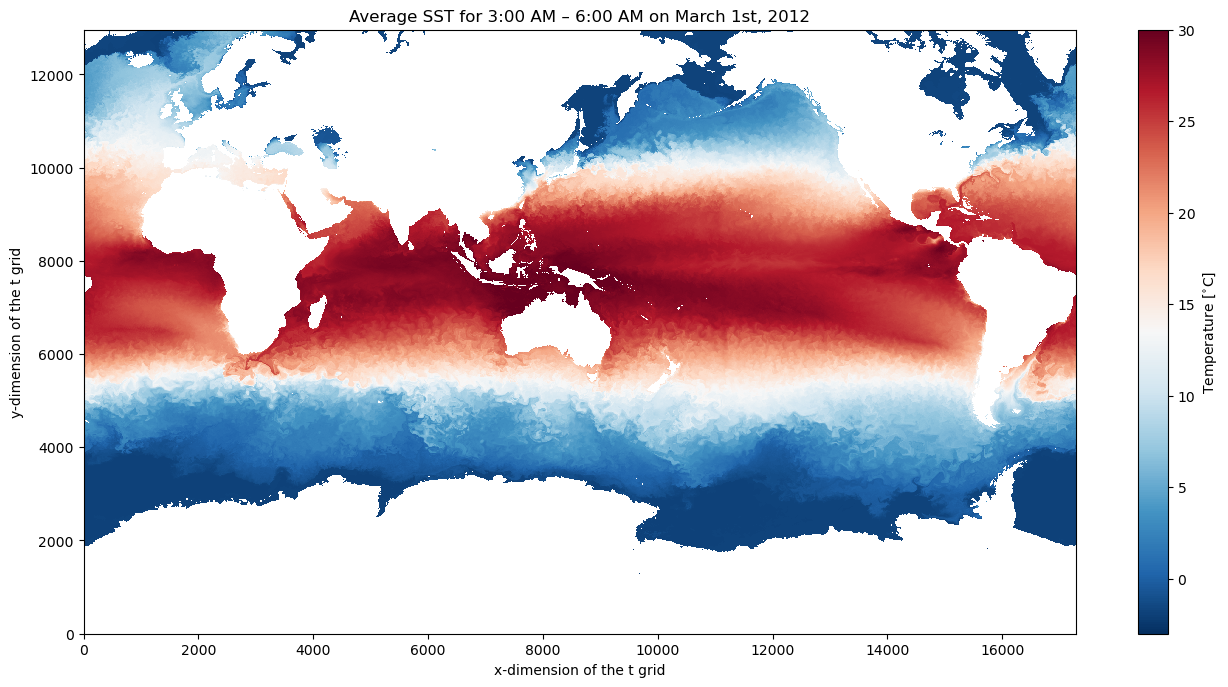

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8), dpi=100)
q = mean_sst.plot()
q.set_clim([-3,30])
q.colorbar.set_label(r"Temperature [$^{\circ}$C]")
plt.title('Average SST for 3:00 AM – 6:00 AM on March 1st, 2012');

# Step 4: Computing derived quantities
XGCM is a python packge for working with the datasets produced by numerical General Circulation Models **(GCMs)** and similar gridded datasets that are amenable to finite volume analysis. In these datasets, different variables are located at different positions with respect to a volume or area element (e.g. cell center, cell face, etc.) xgcm solves the problem of how to interpolate and difference these variables from one position to another.

In [20]:
import xgcm
grid = xgcm.Grid(coords.drop(['k', 'k_p1']), periodic=['X'])  # 丢掉一些参数
grid

<xgcm.Grid>
T Axis (not periodic, boundary=None):
  * center   time
Y Axis (not periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center
X Axis (periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center

## The relative vorticity $\zeta$ (you can think of this as the "spinny-ness" of a fluid) is given by:
\begin{equation}
\zeta = -\frac{\partial u}{\partial y} + \frac{\partial v}{\partial x} 
\end{equation}
On a discrete grid, this operation is approximated by a first-order finite volume difference:

In [21]:
ζ = (-grid.diff(ds.U * coords.dxC, 'Y', boundary='extend')
        +grid.diff(ds.V * coords.dyC, 'X', boundary='extend'))/coords.rAz
ζ

<xarray.DataArray (time: 9030, j_g: 12960, i_g: 17280)>
dask.array<truediv, shape=(9030, 12960, 17280), dtype=float32, chunksize=(1, 4319, 4320), chunktype=numpy.ndarray>
Coordinates:
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00

In [22]:
time_point = '2012-04-01T06'
mean_ζ = ζ.sel(time=time_point).coarsen(i_g=4,j_g=4).mean(['i_g', 'j_g'])

In [23]:
%time mean_ζ = mean_ζ.compute()

[########################################] | 100% Completed |  6.7s
CPU times: user 25.1 s, sys: 6.88 s, total: 32 s
Wall time: 10 s


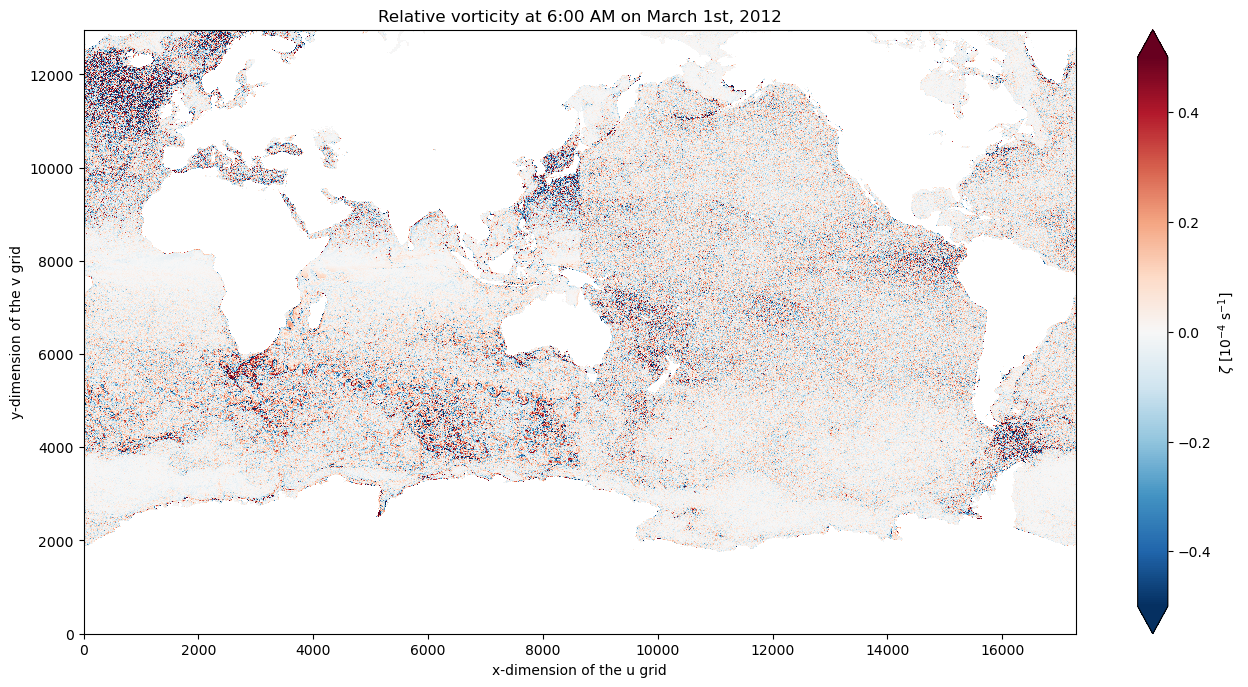

In [24]:
plt.figure(figsize=(16,8), dpi=100)
q = (mean_ζ*1.e4).plot(extend='both')
q.colorbar.set_label(r"$\zeta$ [10$^{-4}$ s$^{-1}$]")
q.set_clim([-0.5,0.5])
plt.title('Relative vorticity at 6:00 AM on March 1st, 2012');

In [25]:
print(time_point)

2012-04-01T06


[########################################] | 100% Completed |  1.8s


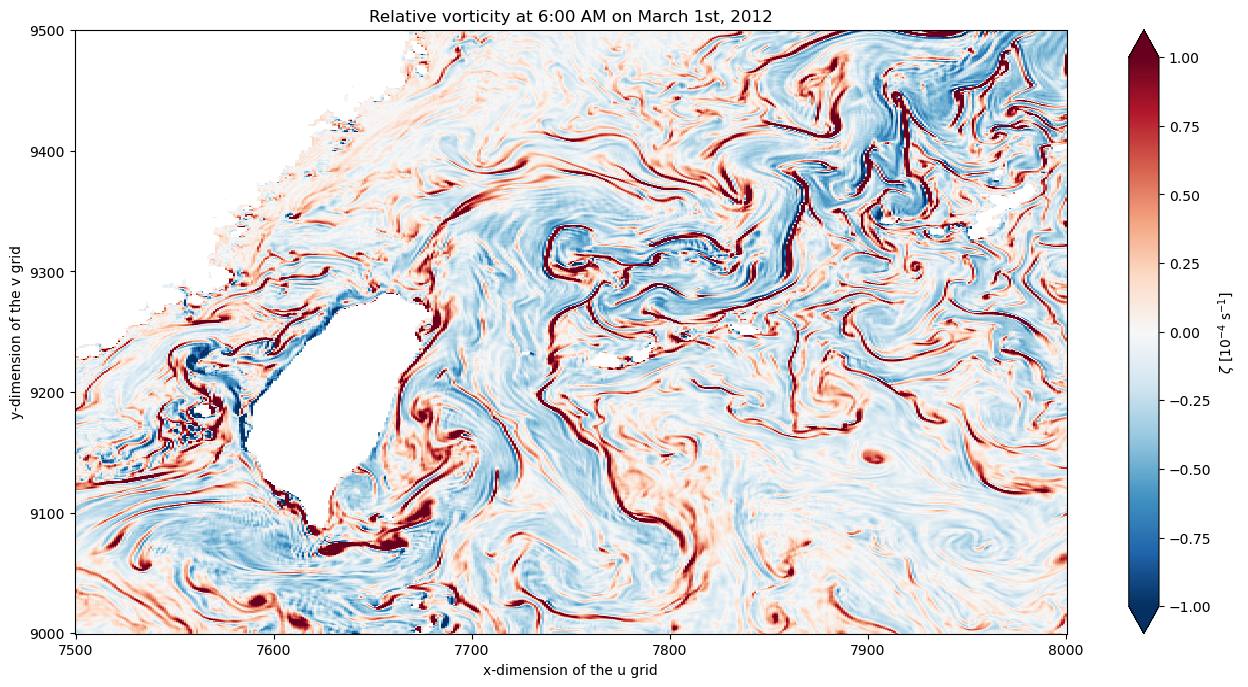

In [26]:
plt.figure(figsize=(16,8), dpi=100)
q = (ζ.sel(time=time_point)*1.e4).sel(i_g=slice(7500,8000), j_g=slice(9000,9500)).plot(extend='both')
q.colorbar.set_label(r"$\zeta$ [10$^{-4}$ s$^{-1}$]")
q.set_clim([-1,1])
plt.title('Relative vorticity at 6:00 AM on March 1st, 2012');

In [27]:
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 17280, j: 12960, time: 9030, i_g: 17280, j_g: 12960)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
Data variables:
    SST      (time, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Eta      (time, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    U        (time, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    V        (time, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>

[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  1.7s


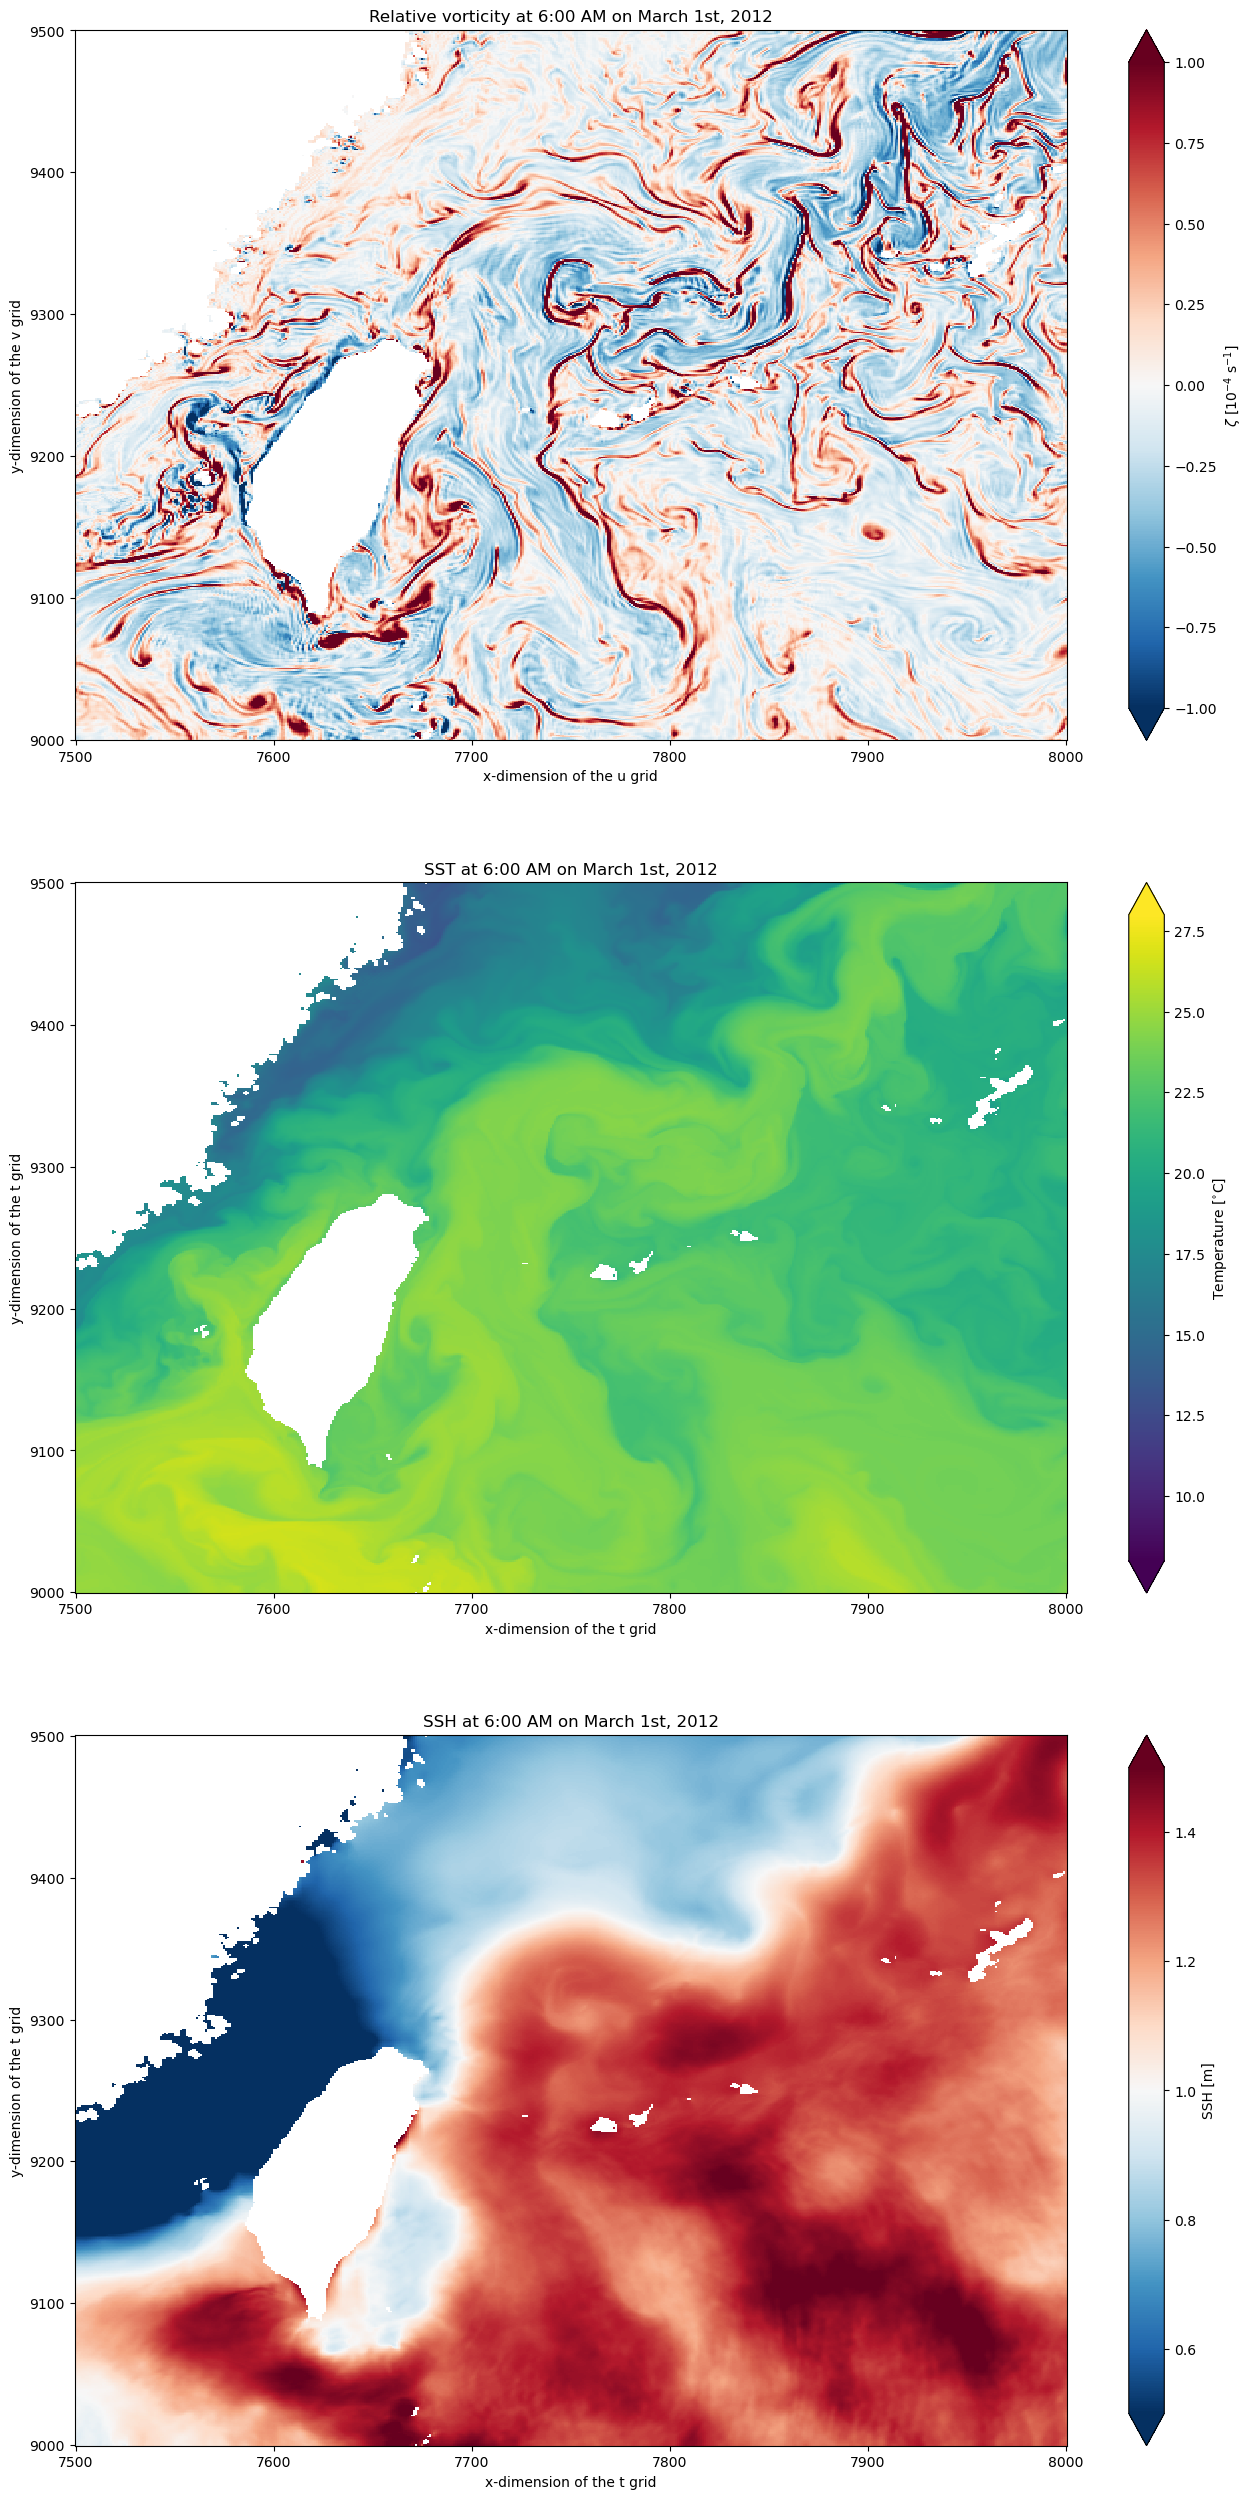

In [28]:
plt.figure(figsize=(16,32), dpi=100)

plt.subplot(3,1,1)
q = (ζ.sel(time=time_point)*1.e4).sel(i_g=slice(7500,8000), j_g=slice(9000,9500)).plot(extend='both')
q.colorbar.set_label(r"$\zeta$ [10$^{-4}$ s$^{-1}$]")
q.set_clim([-1,1])
plt.title('Relative vorticity at 6:00 AM on March 1st, 2012');

plt.subplot(3,1,2)
q = (ds['SST'].sel(time=time_point)).sel(i=slice(7500,8000), j=slice(9000,9500)).plot(extend='both')
q.set_clim([8,28])
q.colorbar.set_label(r"Temperature [$^{\circ}$C]")
plt.title('SST at 6:00 AM on March 1st, 2012');

plt.subplot(3,1,3)
q = (ds['Eta'].sel(time=time_point)).sel(i=slice(7500,8000), j=slice(9000,9500)).plot(extend='both')
q.set_clim([0.5,1.5])
q.colorbar.set_label(r"SSH [m]")
plt.title('SSH at 6:00 AM on March 1st, 2012');

In [38]:
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 17280, j: 12960, time: 9030, i_g: 17280, j_g: 12960)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
Data variables:
    SST      (time, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Eta      (time, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    U        (time, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    V        (time, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>

[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.2s


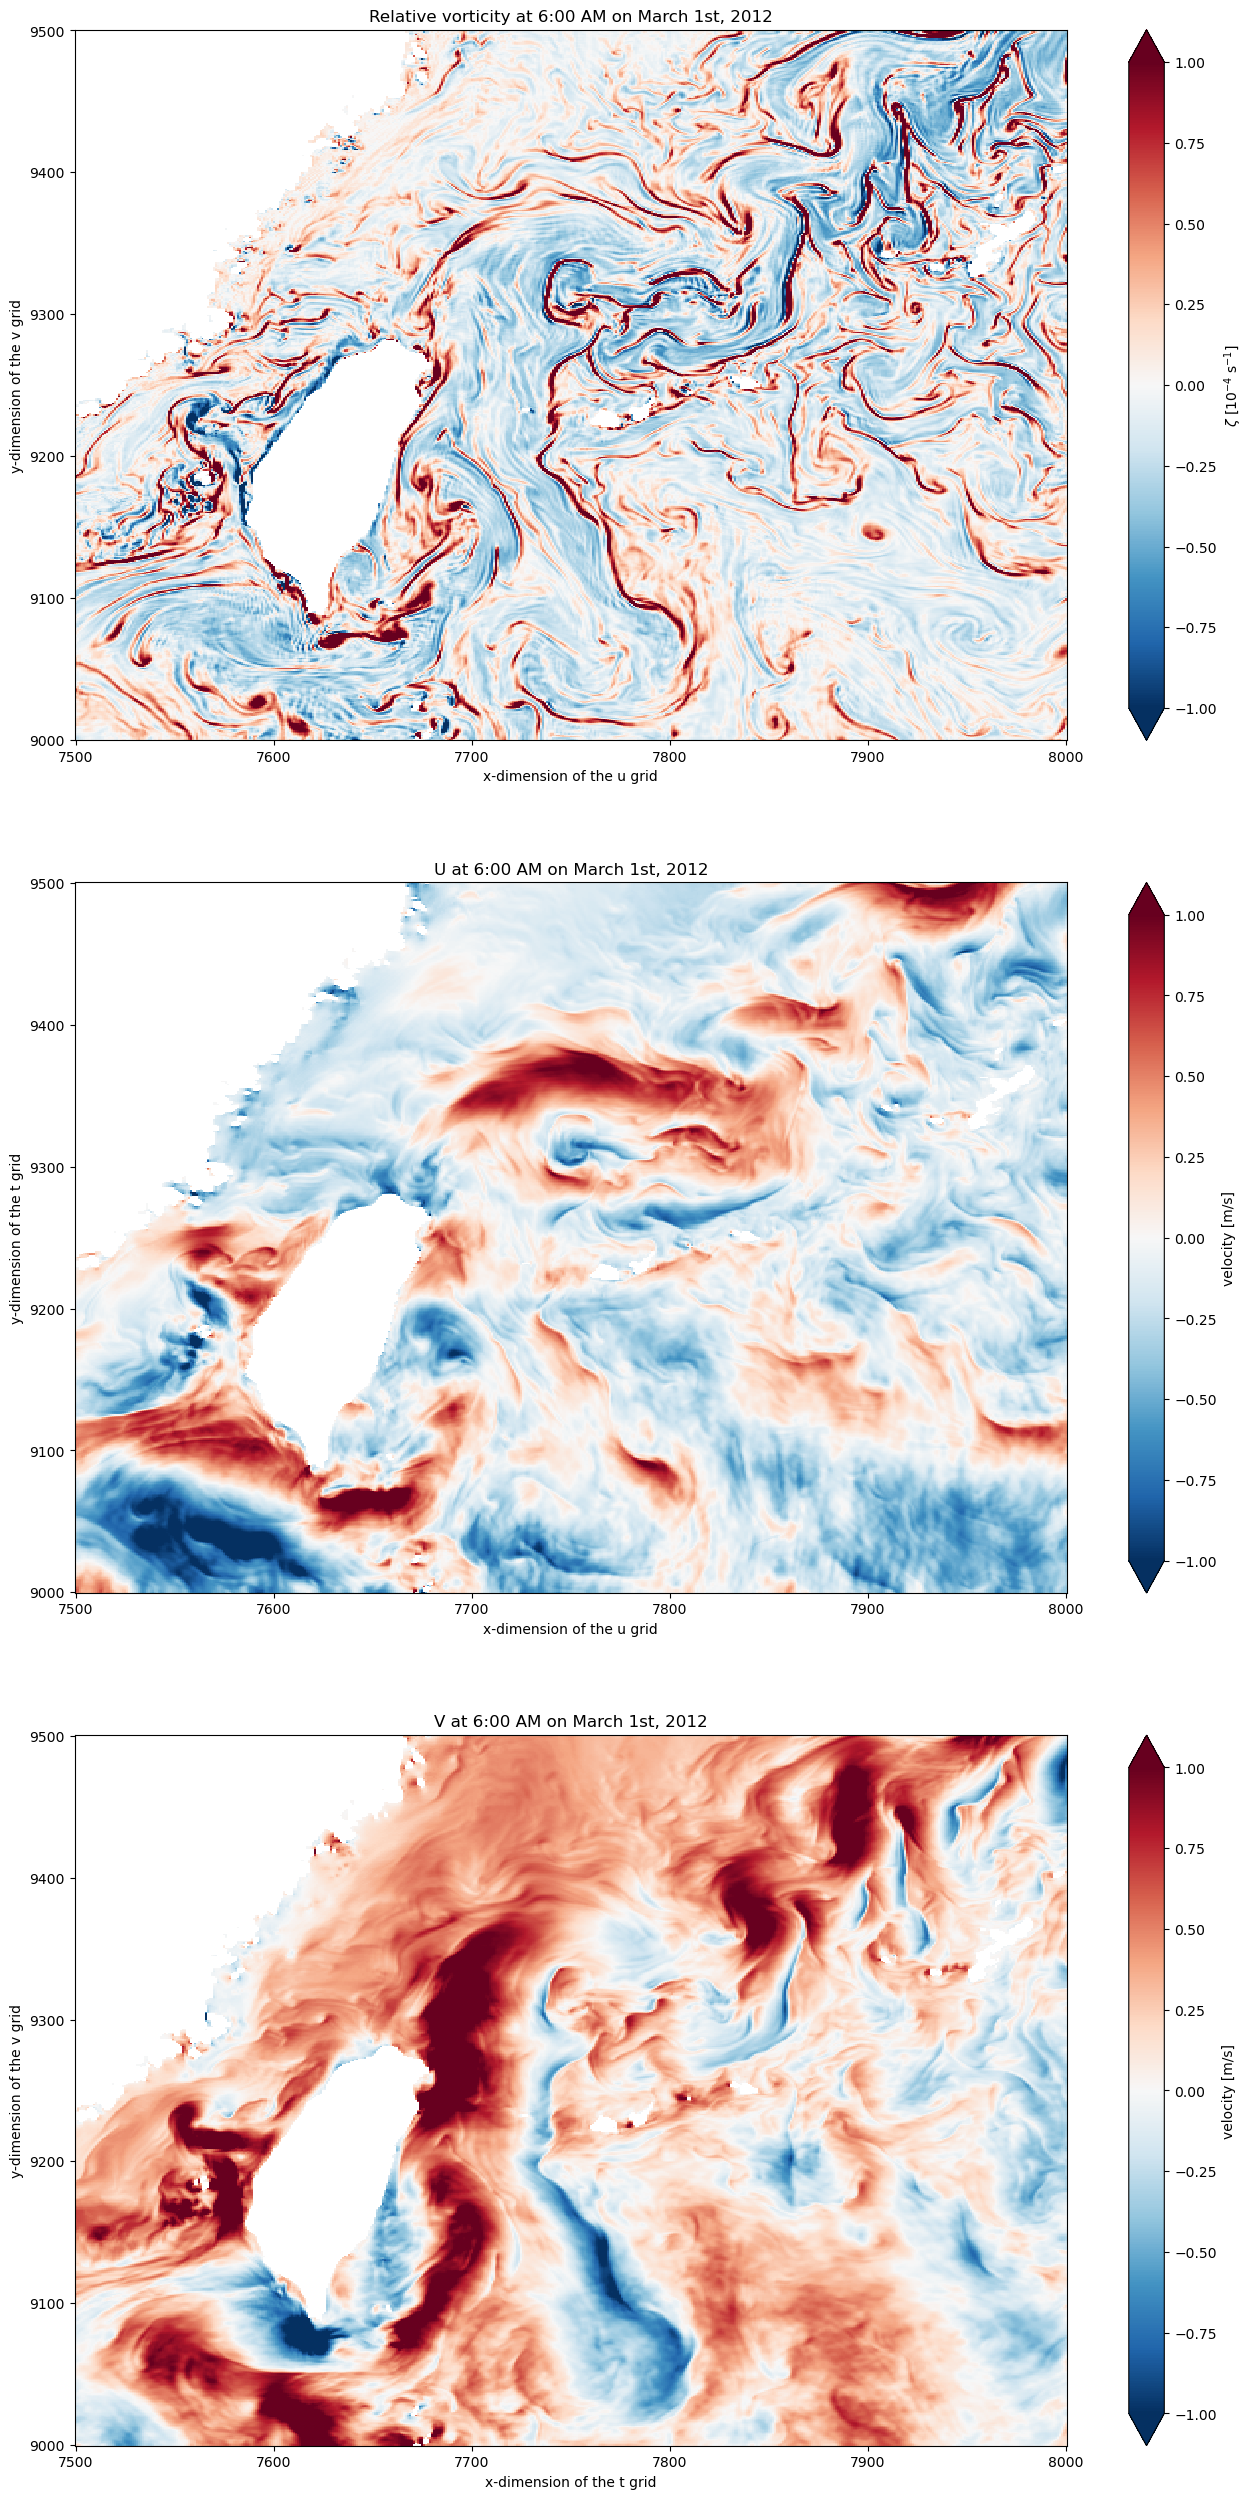

In [29]:
plt.figure(figsize=(16,32), dpi=100)

plt.subplot(3,1,1)
q = (ζ.sel(time=time_point)*1.e4).sel(i_g=slice(7500,8000), j_g=slice(9000,9500)).plot(extend='both')
q.colorbar.set_label(r"$\zeta$ [10$^{-4}$ s$^{-1}$]")
q.set_clim([-1,1])
plt.title('Relative vorticity at 6:00 AM on March 1st, 2012');

plt.subplot(3,1,2)
q = (ds['U'].sel(time=time_point)).sel(i_g=slice(7500,8000), j=slice(9000,9500)).plot(extend='both')
q.set_clim([-1,1])
q.colorbar.set_label(r"velocity [m/s]")
plt.title('U at 6:00 AM on March 1st, 2012');

plt.subplot(3,1,3)
q = (ds['V'].sel(time=time_point)).sel(i=slice(7500,8000), j_g=slice(9000,9500)).plot(extend='both')
q.set_clim([-1,1])
q.colorbar.set_label(r"velocity [m/s]")
plt.title('V at 6:00 AM on March 1st, 2012');